In [10]:
!ls -lh RML2016.10a_dict.dat

-rw-r--r-- 1 root root 614M Dec 23 22:06 RML2016.10a_dict.dat


In [11]:
import os,random
os.environ["KERAS_BACKEND"] = "tensorflow"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import numpy as np
import matplotlib
#matplotlib.use('Tkagg')
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import pickle,sys,h5py
import keras
import keras.backend as K
from keras.callbacks import LearningRateScheduler
from keras.regularizers import *
from keras.optimizers import Adam
from keras.models import model_from_json
import mltools,dataset2016
# import MCLDNN as mcl
import tensorflow as tf
import keras.backend as K
from keras.models import Model
import csv

In [12]:
def output_layer(model,flag=None):
    if flag=='conv2':
        model=Model(inputs=model.inputs,outputs =model.get_layer('conv2').output)
    elif flag=='conv4':
        model=Model(inputs=model.inputs,outputs =model.get_layer('conv4').output)
    elif flag=='cu_dnnlstm_2':
        model=Model(inputs=model.inputs,outputs =model.get_layer('cu_dnnlstm_2').output)
    else:
        return model

    return model

# Set Keras data format as channels_last
K.set_image_data_format('channels_last')
print(K.image_data_format())

channels_last


In [13]:
(mods,snrs,lbl),(X_train,Y_train),(X_val,Y_val),(X_test,Y_test),(train_idx,val_idx,test_idx) = \
    dataset2016.load_data(filename="/content/RML2016.10a_dict.dat")

In [23]:
def get_multi_domain_data(data):
    # 1. IQ Data (Your current input)
    # Shape: (N, 2, 128)
    iq = data

    # 2. Amplitude and Phase (Polar coordinates)
    # Amplitude = sqrt(I^2 + Q^2), Phase = arctan(Q/I)
    amp = np.sqrt(np.power(data[:,0,:], 2) + np.power(data[:,1,:], 2))
    phase = np.arctan2(data[:,1,:], data[:,0,:])
    # Combine them into a 2-channel input
    ap = np.stack((amp, phase), axis=1)

    # 3. FFT (Frequency Magnitude)
    # We take the Fast Fourier Transform to see the frequency spectrum
    complex_data = data[:,0,:] + 1j * data[:,1,:]
    fft_data = np.abs(np.fft.fft(complex_data))
    fft_data = np.fft.fftshift(fft_data, axes=-1) # Center the frequency
    fft_data = np.expand_dims(fft_data, axis=1) # Shape: (N, 1, 128)

    return iq, ap, fft_data

# Transform your datasets
X_train_iq, X_train_ap, X_train_fft = get_multi_domain_data(X_train)
X_test_iq, X_test_ap, X_test_fft = get_multi_domain_data(X_test)


In [29]:
import os
import keras
from keras.models import Model
from keras.layers import Input, Dense, Conv1D, concatenate, Reshape, Conv2D, LSTM, BatchNormalization, AlphaDropout
from keras.utils import plot_model
from keras.layers import Bidirectional, MultiHeadAttention, LayerNormalization, GlobalAveragePooling1D

from keras.layers import Input, Conv1D, Conv2D, Reshape, concatenate, BatchNormalization, LSTM, Bidirectional, MultiHeadAttention, GlobalAveragePooling1D, Dense, AlphaDropout
from keras.models import Model

In [31]:
def MCLDNN_Pro(classes=11):
    # --- BRANCH 1: IQ (Corrected Shape Math) ---
    in_iq = Input(shape=(2, 128, 1), name='iq_input')
    x1 = Conv2D(64, (2, 8), padding='same', activation='relu', name='iq_conv_2d')(in_iq)
    x1 = BatchNormalization(name='iq_bn_1')(x1)
    # Correcting the shape: (None, 2, 128, 64) -> (None, 128, 128)
    # We use Reshape to merge the height (2) into the filter dimension or just flatten the height
    x1 = Reshape((128, 128), name='iq_reshape')(x1)

    # --- BRANCH 2: AP (Amplitude/Phase) ---
    in_ap = Input(shape=(2, 128), name='ap_input')
    # Permute to (128, 2) to treat time as the sequence length
    x2_p = Permute((2, 1), name='ap_permute')(in_ap)
    x2 = Conv1D(64, 8, padding='same', activation='relu', name='ap_conv_1d')(x2_p)
    x2 = BatchNormalization(name='ap_bn_1')(x2)

    # --- BRANCH 3: FFT (Spectral) ---
    in_fft = Input(shape=(1, 128), name='fft_input')
    x3_p = Permute((2, 1), name='fft_permute')(in_fft)
    x3 = Conv1D(64, 8, padding='same', activation='relu')(x3_p)
    x3 = BatchNormalization(name='fft_bn_1')(x3)

    # --- FUSION ---
    # Now all branches have 128 time-steps, making the concatenation possible
    merged = concatenate([x1, x2, x3], axis=-1)

    # Bi-LSTM + Attention
    x = Bidirectional(LSTM(128, return_sequences=True), name='bi_lstm')(merged)
    attn = MultiHeadAttention(num_heads=4, key_dim=128, name='attention')(x, x)
    x = GlobalAveragePooling1D()(attn)

    # Final Classifier
    x = Dense(128, activation='selu', kernel_initializer='lecun_normal', name='dense_1')(x)
    x = AlphaDropout(0.5)(x)
    output = Dense(classes, activation='softmax', name='softmax_final')(x)

    return Model(inputs=[in_iq, in_ap, in_fft], outputs=output)

In [32]:
def MCLDNN(weights=None, input_shape1=[2,128], input_shape2=[128,1], classes=11, **kwargs):
    dr = 0.5

    input1 = Input(input_shape1+[1], name='input1')
    input2 = Input(input_shape2, name='input2')
    input3 = Input(input_shape2, name='input3')

    # SeparateChannel Combined Convolutional Neural Networks
    # --- CNN Section (Increased filters for more capacity) ---
    x1 = Conv2D(64, (2,8), padding='same', activation="relu")(input1)
    x1 = BatchNormalization()(x1)

    x2 = Conv1D(64, 8, padding='causal', activation="relu")(input2)
    x2 = BatchNormalization()(x2)
    x2_reshape = Reshape([-1, 128, 64])(x2)

    x3 = Conv1D(64, 8, padding='causal', activation="relu")(input3)
    x3 = BatchNormalization()(x3)
    x3_reshape = Reshape([-1, 128, 64])(x3)

    x = concatenate([x2_reshape, x3_reshape], axis=1)
    x = Conv2D(64, (1,8), padding='same', activation="relu")(x)
    x = BatchNormalization()(x)

    x = concatenate([x1, x])
    x = Conv2D(128, (2,5), padding='valid', activation="relu")(x)
    x = BatchNormalization()(x)

    # --- NEW: Sequence Processing with Bi-LSTM ---
    x = Reshape(target_shape=((124, 128)))(x)
    # Bidirectional captures context from both ends of the signal
    x = Bidirectional(LSTM(units=128, return_sequences=True, dropout=0.2))(x)

    # --- NEW: Multi-Head Attention Layer ---
    # This helps the model "attend" to specific phase shifts
    attention_out = MultiHeadAttention(num_heads=4, key_dim=128)(x, x)
    x = LayerNormalization()(attention_out + x) # Residual connection

    x = GlobalAveragePooling1D()(x) # Better than a simple Flatten for signals

    # DNN - SELU + AlphaDropout + Lecun_normal is a powerful combo
    x = Dense(128, activation='selu', kernel_initializer='lecun_normal', name='fc1')(x)
    x = AlphaDropout(dr)(x)

    x = Dense(128, activation='selu', kernel_initializer='lecun_normal', name='fc2')(x)
    x = AlphaDropout(dr)(x)

    x = Dense(classes, activation='softmax', name='softmax')(x)

    model = Model(inputs=[input1, input2, input3], outputs=x)

    if weights is not None:
        model.load_weights(weights)

    return model

# if __name__ == '__main__':
#     # Changed classes to 11 for RML2016.10a
#     model = MCLDNN(None, classes=11)

#     # Using learning_rate instead of lr
#     adam = keras.optimizers.Adam(learning_rate=0.0001, clipnorm=1.0)

#     model.summary()

In [35]:
model=MCLDNN_Pro()
old_model = MCLDNN(weights="weights/weights3.keras")
# 3. UPDATED layer_map using the names from your error message
layer_map = {
    'conv2d_3': 'iq_conv_2d',  # This was your old 'input1' convolution
    'batch_normalization_5': 'iq_bn_1'
}

# 4. Inject weights
for old_name, new_name in layer_map.items():
    try:
        weights = old_model.get_layer(old_name).get_weights()
        new_model.get_layer(new_name).set_weights(weights)
        print(f"Successfully transferred weights from {old_name} to {new_name}")
    except Exception as e:
        print(f"Could not transfer {old_name}: {e}")

model.compile(
    loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.1),
    metrics=['accuracy'],
    optimizer=keras.optimizers.Adam(learning_rate=0.0005, clipnorm=1.0)
)
model.summary()

Could not transfer conv2d_3: No such layer: conv2d_3. Existing layers are: ['input2', 'input3', 'conv1d_9', 'conv1d_10', 'batch_normalization_16', 'batch_normalization_17', 'reshape_10', 'reshape_11', 'input1', 'concatenate_9', 'conv2d_9', 'conv2d_10', 'batch_normalization_15', 'batch_normalization_18', 'concatenate_10', 'conv2d_11', 'batch_normalization_19', 'reshape_12', 'bidirectional_3', 'multi_head_attention_3', 'layer_normalization_3', 'global_average_pooling1d_6', 'fc1', 'alpha_dropout_9', 'fc2', 'alpha_dropout_10', 'softmax'].
Could not transfer batch_normalization_5: No such layer: batch_normalization_5. Existing layers are: ['input2', 'input3', 'conv1d_9', 'conv1d_10', 'batch_normalization_16', 'batch_normalization_17', 'reshape_10', 'reshape_11', 'input1', 'concatenate_9', 'conv2d_9', 'conv2d_10', 'batch_normalization_15', 'batch_normalization_18', 'concatenate_10', 'conv2d_11', 'batch_normalization_19', 'reshape_12', 'bidirectional_3', 'multi_head_attention_3', 'layer_norma

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ iq_input            │ (None, 2, 128, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ap_input            │ (None, 2, 128)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fft_input           │ (None, 1, 128)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ iq_conv_2d (Conv2D) │ (None, 2, 128,    │      1,088 │ iq_input[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ap_permute          │ (None, 128, 2)    │          0 │ ap_input[0][0]    │
│ (Permute)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fft_permute         │ (None, 128, 1)    │          0 │ fft_input[0][0]   │
│ (Permute)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ iq_bn_1             │ (None, 2, 128,    │        256 │ iq_conv_2d[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ap_conv_1d (Conv1D) │ (None, 128, 64)   │      1,088 │ ap_permute[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1d_8 (Conv1D)   │ (None, 128, 64)   │        576 │ fft_permute[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ iq_reshape          │ (None, 128, 128)  │          0 │ iq_bn_1[0][0]     │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ap_bn_1             │ (None, 128, 64)   │        256 │ ap_conv_1d[0][0]  │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fft_bn_1            │ (None, 128, 64)   │        256 │ conv1d_8[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 128, 256)  │          0 │ iq_reshape[0][0], │
│ (Concatenate)       │                   │            │ ap_bn_1[0][0],    │
│                     │                   │            │ fft_bn_1[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bi_lstm             │ (None, 128, 256)  │    394,240 │ concatenate_8[0]… │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 128, 256)  │    526,080 │ bi_lstm[0][0],    │
│ (MultiHeadAttentio… │                   │            │ bi_lstm[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 256)       │          0 │ attention[0][0]   │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     32,896 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 958,155 (3.66 MB)

 Trainable params: 957,771 (3.65 MB)

 Non-trainable params: 384 (1.50 KB)

In [36]:
filepath = 'weights/weights3.keras'



modtype=['8PSK','AM-DSB','AM-SSB','BPSK','CPFSK','GFSK','4-PAM','16-QAM','64-QAM','QPSK','WBFM']


In [37]:
nb_epoch = 100     # number of epochs to train on
batch_size = 1024

In [38]:
def get_triple_data(X):
    # Stream 1: IQ (Matches shape [2, 128, 1])
    X_iq = np.expand_dims(X, axis=-1)

    # Stream 2: AP (Matches shape [2, 128])
    X_amp = np.sqrt(np.power(X[:,0,:], 2) + np.power(X[:,1,:], 2))
    X_phase = np.arctan2(X[:,1,:], X[:,0,:])
    X_ap = np.stack((X_amp, X_phase), axis=1)

    # Stream 3: FFT (Matches shape [1, 128])
    X_complex = X[:,0,:] + 1j * X[:,1,:]
    X_fft = np.abs(np.fft.fft(X_complex))
    X_fft = np.fft.fftshift(X_fft, axes=-1)
    X_fft = np.expand_dims(X_fft, axis=1)

    return [X_iq, X_ap, X_fft]

# Prepare data
X_train_triple = get_triple_data(X_train)
X_test_triple = get_triple_data(X_test)

In [39]:
X_train_triple = get_triple_data(X_train)
X_val_triple = get_triple_data(X_val)
X_test_triple = get_triple_data(X_test)

Epoch 1/100

Epoch 1: val_loss improved from inf to 4.68796, saving model to weights/weights3.keras
129/129 - 65s - 507ms/step - accuracy: 0.2624 - loss: 2.1498 - val_accuracy: 0.2287 - val_loss: 4.6880 - learning_rate: 5.0000e-04
Epoch 2/100

Epoch 2: val_loss improved from 4.68796 to 2.31749, saving model to weights/weights3.keras
129/129 - 60s - 466ms/step - accuracy: 0.3865 - loss: 1.8224 - val_accuracy: 0.3815 - val_loss: 2.3175 - learning_rate: 5.0000e-04
Epoch 3/100

Epoch 3: val_loss improved from 2.31749 to 1.97734, saving model to weights/weights3.keras
129/129 - 60s - 466ms/step - accuracy: 0.4176 - loss: 1.7524 - val_accuracy: 0.4237 - val_loss: 1.9773 - learning_rate: 5.0000e-04
Epoch 4/100

Epoch 4: val_loss improved from 1.97734 to 1.90115, saving model to weights/weights3.keras
129/129 - 60s - 464ms/step - accuracy: 0.4562 - loss: 1.6998 - val_accuracy: 0.4759 - val_loss: 1.9012 - learning_rate: 5.0000e-04
Epoch 5/100

Epoch 5: val_loss improved from 1.90115 to 1.85720,

FileNotFoundError: [Errno 2] No such file or directory: 'figure/total_loss.png'

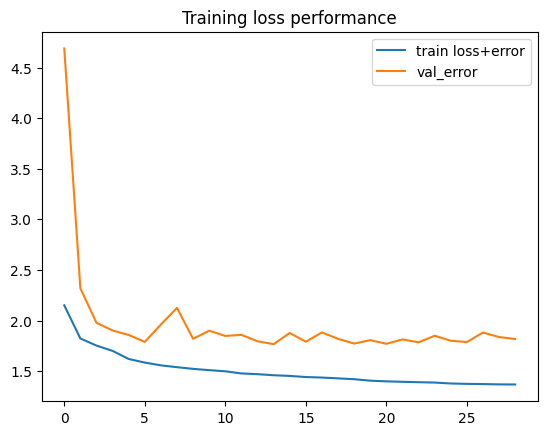

In [40]:
history = model.fit(x=X_train_triple,
    y=Y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_data=(X_val_triple, Y_val),
    # validation_data=([X_test,X1_test,X2_test],Y_test),
    callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath,
        monitor='val_loss',
        verbose=1,
        save_best_only=True,
        mode='min'
    ),

    keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        verbose=1,
        min_lr=0.000001
    ),

    keras.callbacks.EarlyStopping(
        monitor='val_loss',
        patience=15,
        verbose=1,
        mode='min',
        restore_best_weights=True
    )
])
mltools.show_history(history)
# Show simple version of performance
score = model.evaluate(X_test_triple, Y_test, verbose=1, batch_size=batch_size)
print(score)

344/344 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step


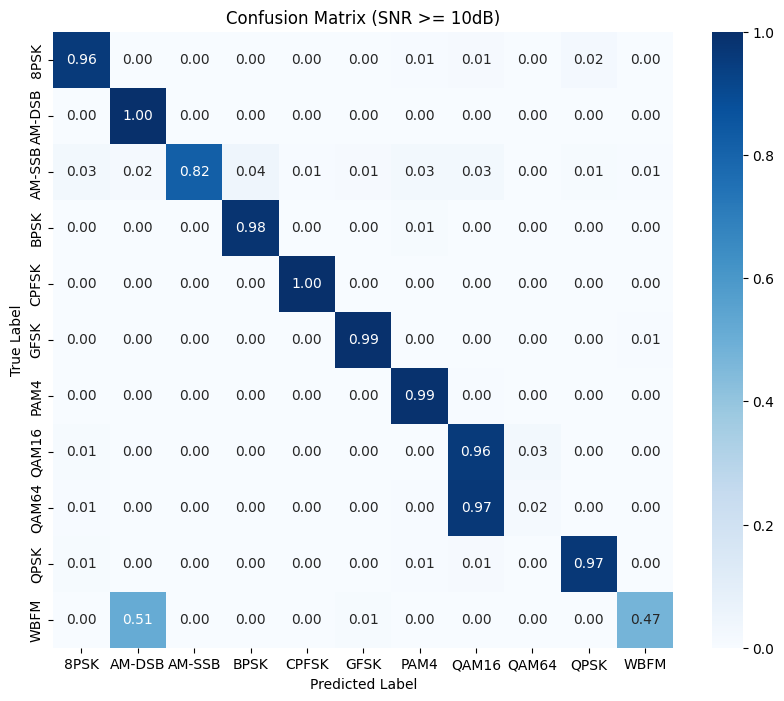

In [43]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, X_test_list, Y_test, test_idx, mods, min_snr=10):
    # Filter for high SNR samples only
    test_snrs = np.array([lbl[i][1] for i in test_idx])
    high_snr_idx = np.where(test_snrs >= min_snr)

    X_high = [input_data[high_snr_idx] for input_data in X_test_list]
    Y_high = Y_test[high_snr_idx]

    # Get predictions
    y_pred = np.argmax(model.predict(X_high), axis=1)
    y_true = np.argmax(Y_high, axis=1)

    # Create Matrix
    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap='Blues',
                xticklabels=mods, yticklabels=mods)
    plt.title(f'Confusion Matrix (SNR >= {min_snr}dB)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Run it
# 1. Prepare the triple-stream test data
X_test_triple = get_triple_data(X_test) # This creates [IQ, AP, FFT]

# 2. Run your functions using this list
plot_confusion_matrix(model, X_test_triple, Y_test, test_idx, mods)


69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
SNR -20dB | Accuracy: 0.1232
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
SNR -18dB | Accuracy: 0.1350
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
SNR -16dB | Accuracy: 0.1427
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
SNR -14dB | Accuracy: 0.1686
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
SNR -12dB | Accuracy: 0.1868
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
SNR -10dB | Accuracy: 0.2468
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
SNR  -8dB | Accuracy: 0.3136
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
SNR  -6dB | Accuracy: 0.4227
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
SNR  -4dB | Accuracy: 0.5314
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
SNR  -2dB | Accuracy: 0.6573
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
SNR   0dB | Accuracy: 0.7682
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
SNR   2dB | Accuracy: 0.8168
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
SNR   4dB | Accuracy: 0.8209
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step
SNR   6dB | Accuracy: 0.8345
69/69 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
SNR   8

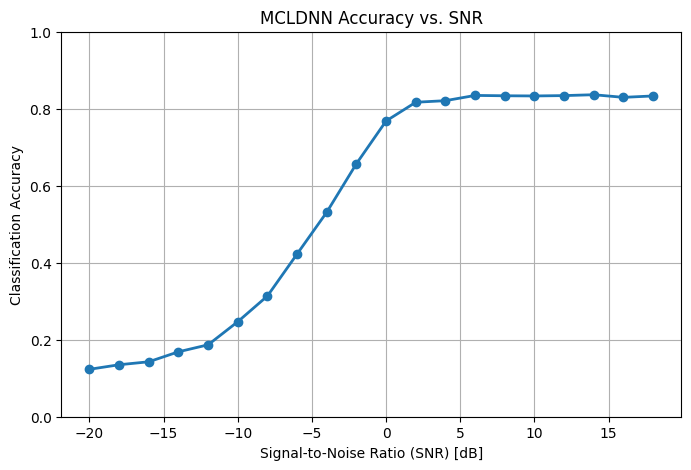

In [44]:
import numpy as np
import matplotlib.pyplot as plt

def plot_accuracy_per_snr(model, X_test_list, Y_test, test_idx, snrs):
    acc = {}
    # Extract the SNR for each test sample using the test indices
    test_snrs = [lbl[i][1] for i in test_idx]

    for snr in snrs:
        # Filter indices where SNR matches
        idx = np.where(np.array(test_snrs) == snr)

        # Predict on this specific SNR group
        X_test_snr = [input_data[idx] for input_data in X_test_list]
        Y_test_snr = Y_test[idx]

        prediction = model.predict(X_test_snr)

        # Calculate accuracy
        y_pred = np.argmax(prediction, axis=1)
        y_true = np.argmax(Y_test_snr, axis=1)

        current_acc = np.mean(y_pred == y_true)
        acc[snr] = current_acc
        print(f"SNR {snr: >3}dB | Accuracy: {current_acc:.4f}")

    # Plotting
    plt.figure(figsize=(8, 5))
    plt.plot(snrs, [acc[s] for s in snrs], marker='o', linestyle='-', linewidth=2)
    plt.xlabel('Signal-to-Noise Ratio (SNR) [dB]')
    plt.ylabel('Classification Accuracy')
    plt.title('MCLDNN Accuracy vs. SNR')
    plt.grid(True)
    plt.ylim(0, 1)
    plt.show()

# Run it
plot_accuracy_per_snr(model, X_test_triple, Y_test, test_idx, snrs)

43/43 ━━━━━━━━━━━━━━━━━━━━ 7s 153ms/step


FileNotFoundError: [Errno 2] No such file or directory: 'figure/mclstm_total_confusion.png'

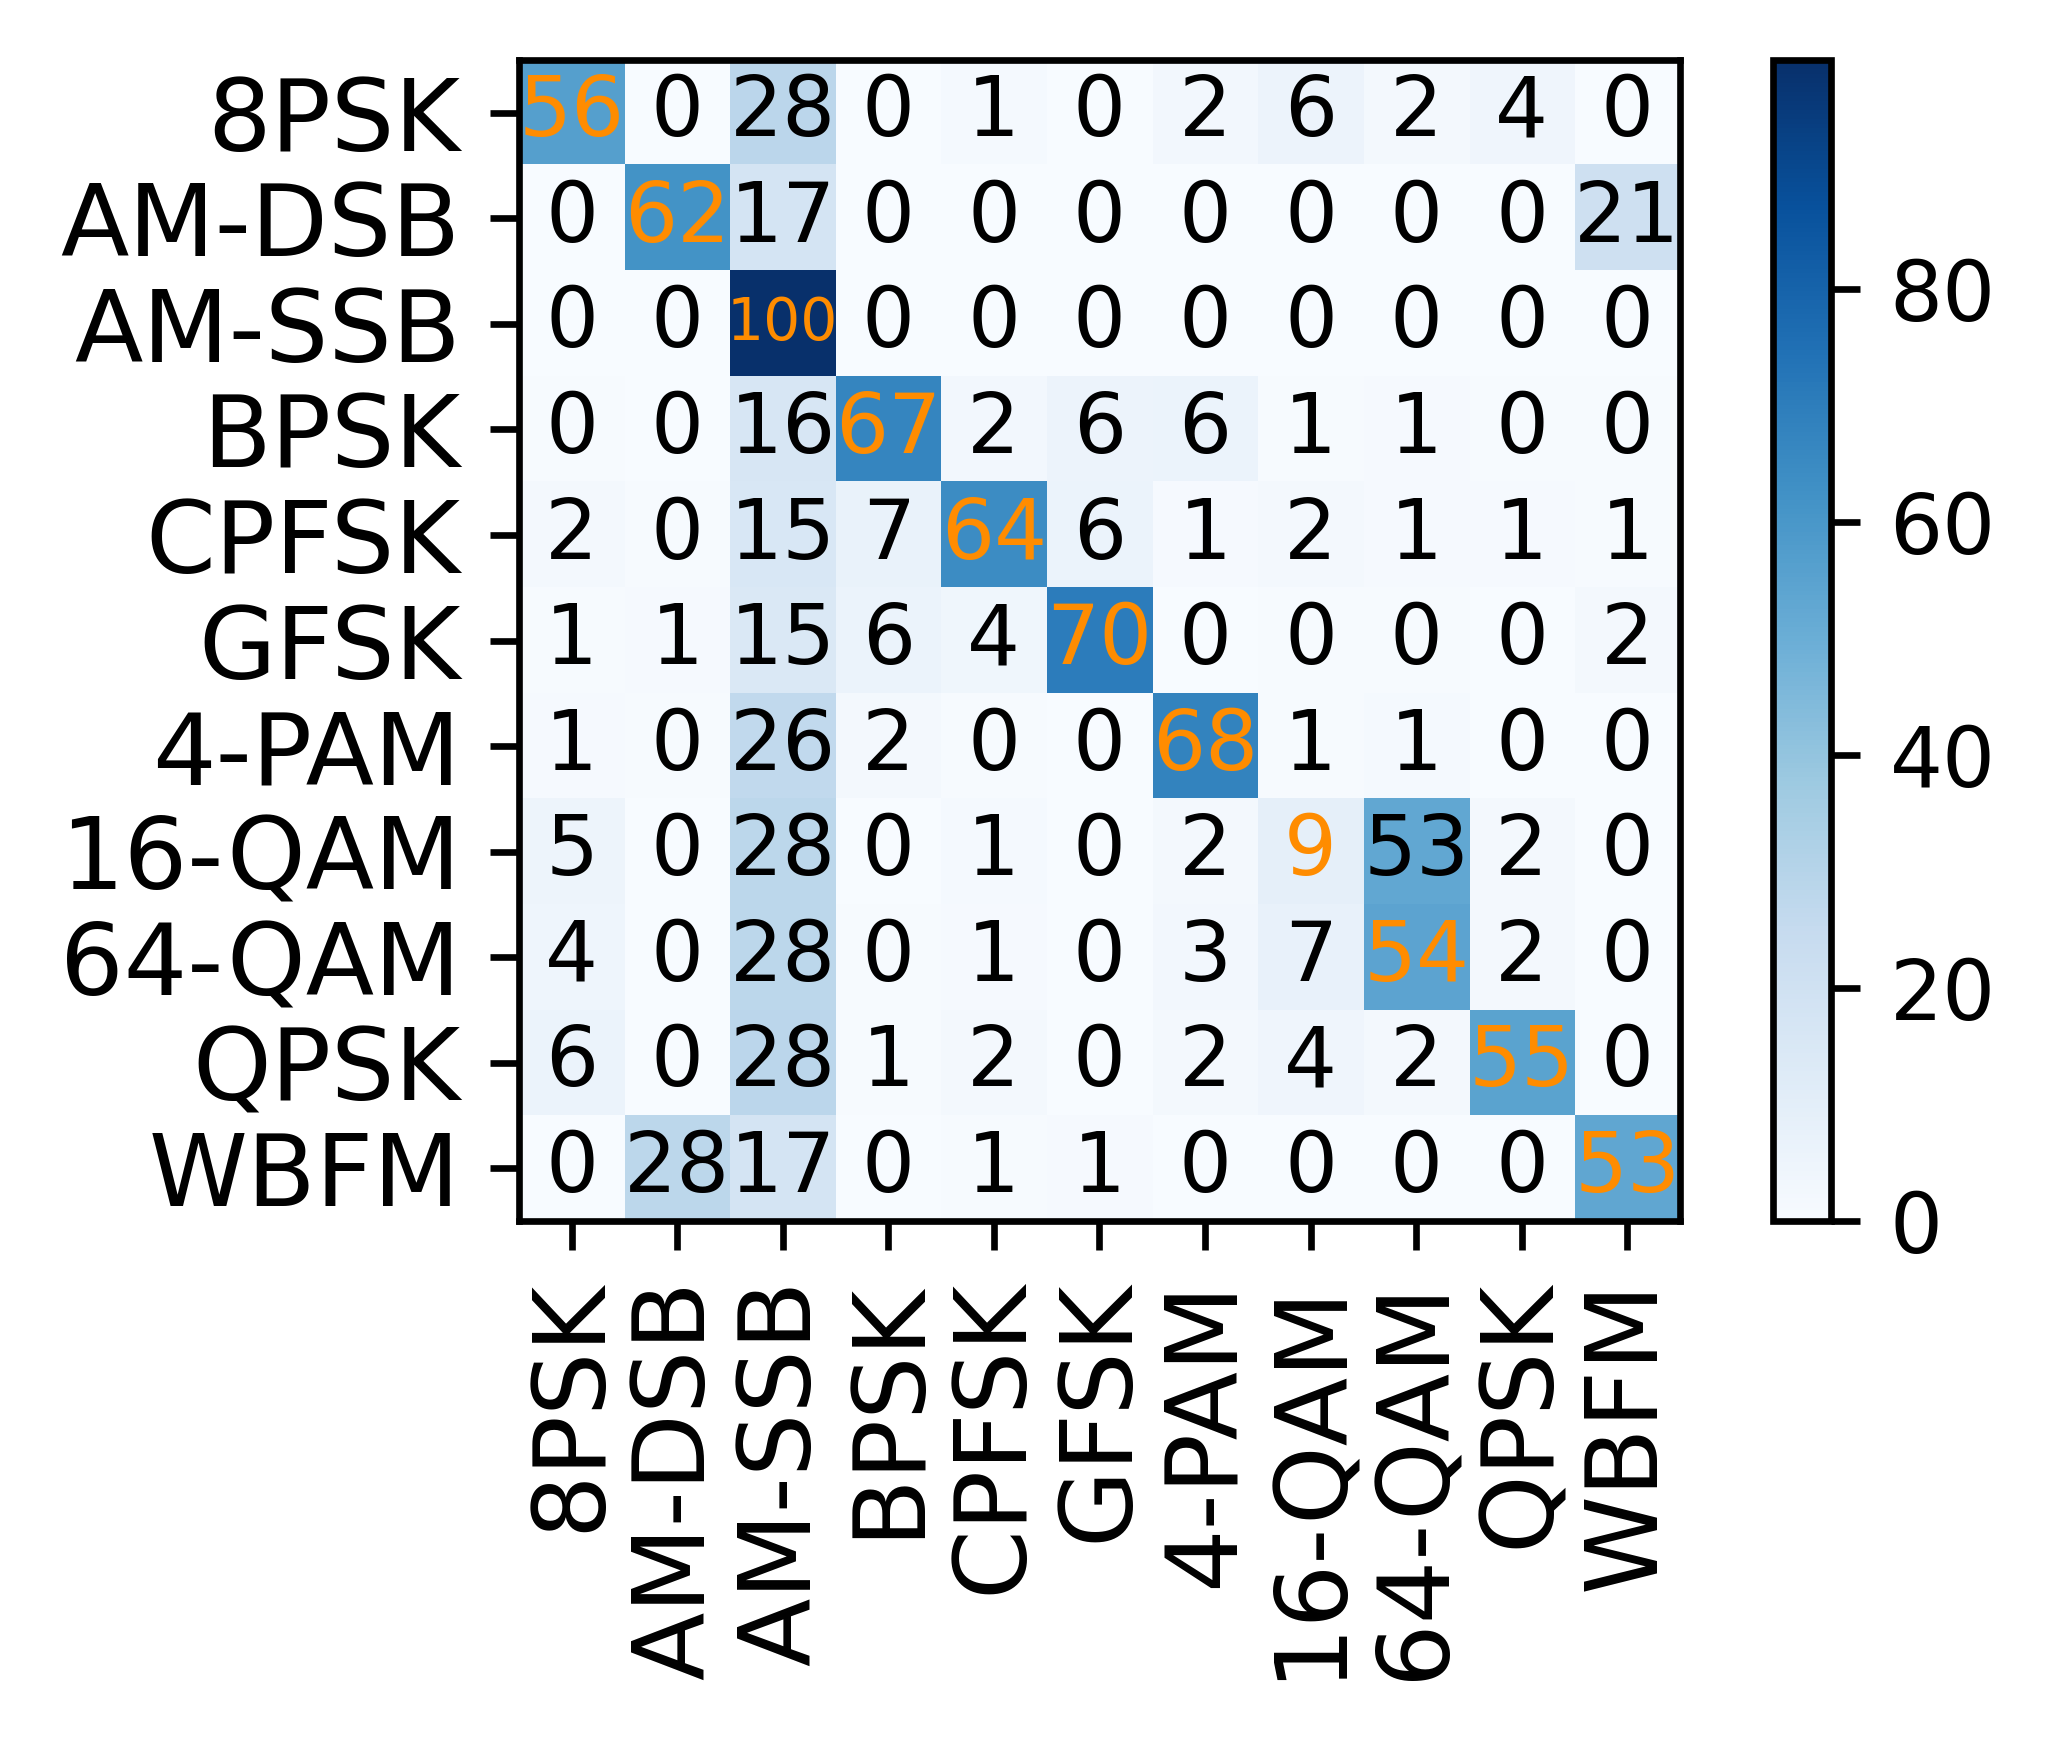

In [22]:
def predict(model):
    model.load_weights(filepath)
    # Plot confusion matrix
    test_Y_hat = model.predict([X_test,X1_test,X2_test], batch_size=batch_size)
    confnorm,_,_ = mltools.calculate_confusion_matrix(Y_test,test_Y_hat,classes)
    mltools.plot_confusion_matrix(confnorm, labels=['8PSK','AM-DSB','AM-SSB','BPSK','CPFSK','GFSK','4-PAM','16-QAM','64-QAM','QPSK','WBFM'],save_filename='figure/mclstm_total_confusion.png')
    # Plot confusion matrix
    acc = {}
    acc_mod_snr = np.zeros( (len(classes),len(snrs)) )
    i = 0
    for snr in snrs:

        # Extract classes @ SNR
        test_SNRs = [lbl[x][1] for x in test_idx]
        test_X1_i = X1_test[np.where(np.array(test_SNRs) == snr)]
        test_X2_i = X2_test[np.where(np.array(test_SNRs) == snr)]
        test_X_i=X_test[np.where(np.array(test_SNRs) == snr)]
        test_Y_i = Y_test[np.where(np.array(test_SNRs) == snr)]

        # Estimate classes
        test_Y_i_hat = model.predict([test_X_i,test_X1_i,test_X2_i])
        confnorm_i,cor,ncor = mltools.calculate_confusion_matrix(test_Y_i,test_Y_i_hat,classes)
        acc[snr] = 1.0 * cor / (cor + ncor)
        result = cor / (cor + ncor)
        with open('acc111.csv', 'a', newline='') as f0:
            write0 = csv.writer(f0)
            write0.writerow([result])
        mltools.plot_confusion_matrix(confnorm_i, labels=['8PSK','AM-DSB','AM-SSB','BPSK','CPFSK','GFSK','4-PAM','16-QAM','64-QAM','QPSK','WBFM'], title="Confusion Matrix" ,save_filename="figure/Confusion(SNR=%d)(ACC=%2f).png" % (snr,100.0*acc[snr]))
        acc_mod_snr[:,i] = np.round(np.diag(confnorm_i)/np.sum(confnorm_i,axis=1),3)
        i = i +1

    # Plot acc of each mod in one picture
    dis_num=11
    for g in range(int(np.ceil(acc_mod_snr.shape[0]/dis_num))):
        assert (0 <= dis_num <= acc_mod_snr.shape[0])
        beg_index = g*dis_num
        end_index = np.min([(g+1)*dis_num,acc_mod_snr.shape[0]])

        plt.figure(figsize=(12, 10))
        plt.xlabel("Signal to Noise Ratio")
        plt.ylabel("Classification Accuracy")
        plt.title("Classification Accuracy for Each Mod")

        for i in range(beg_index,end_index):
            plt.plot(snrs, acc_mod_snr[i], label=classes[i])
            # 设置数字标签
            for x, y in zip(snrs, acc_mod_snr[i]):
                plt.text(x, y, y, ha='center', va='bottom', fontsize=8)

        plt.legend()
        plt.grid()
        plt.savefig('figure/acc_with_mod_{}.png'.format(g+1))
        plt.close()
    # Save acc for mod per SNR
    fd = open('predictresult/acc_for_mod.dat', 'wb')
    pickle.dump((acc_mod_snr), fd)
    fd.close()

    # Save results to a pickle file for plotting later
    print(acc)
    fd = open('predictresult/acc.dat','wb')
    pickle.dump( (acc) , fd )

    # Plot accuracy curve
    plt.plot(snrs, list(map(lambda x: acc[x], snrs)))
    plt.xlabel("Signal to Noise Ratio")
    plt.ylabel("Classification Accuracy")
    plt.title(" Classification Accuracy on RadioML 2016.10 Alpha")
    plt.tight_layout()
    plt.savefig('figure/each_acc.png')
predict(model)